### 1. package imports

In [11]:
from pathlib import Path
import pandas as pd
import xarray as xr
import geopandas as gpd
from shapely.geometry import box
from tqdm.notebook import tqdm as ntqdm
import matplotlib.pyplot as plt


### 2. specify folders and paths

In [2]:
# INPUTS
dispatch_sm = Path("/mnt/RAID2/ACCWA/h18v04/dispatch_hybrid_21r_update") #### SMAP SM
start_time = "20230101" # format = yearmonthday = yyyymmdd
end_time   = "20230301"
shapefile_path = Path("/data/PhDGiovanni/5.IrriEst/DATA/INSITU/MUGA/SHAPEFILES/shpa_MUGA/AIGUA_CONQUES_MUGA.shp")
shapefile = gpd.read_file(shapefile_path)
### if you don't have a shapefile ready, then comment the previous 2 lines and uncomment the following lines and specify just the border extent 
# west = 0.6
# south = 41.5
# east = 1.1
# north = 41.8
# shapefile = gpd.GeoDataFrame(geometry=[box(west, south, east, north)], crs = "EPSG:4326")

# OUTPUT
outfold = Path(f"/data/PhDGiovanni/5.IrriEst/DATA/SATELLITES/MUGA/MUGA_Dispatch_SMAP") # here a folder called "Dispatch_SMAP21r_1km.zarr" will be created

### 3. run conversion

In [5]:
fold_satellite_sm  = outfold / 'Urgell_Dispatch_SMAP' #### SMAP
fold_satellite_sm.mkdir(exist_ok=True, parents=True)
file_sm_zarr = fold_satellite_sm / 'Dispatch_SMAP21r_1km.zarr' #### SMAP
start_time = pd.Timestamp(start_time)
end_time = pd.Timestamp(end_time)

if not file_sm_zarr.exists(): # do not repeat if the file already exists
    geometries = shapefile.dissolve().to_crs(4326) # dissolve all the polygons in the shapefile
    xmin, ymin, xmax, ymax = geometries.total_bounds # get the boarder of the shapefile
    soil_moisture_files = list(dispatch_sm.glob('*/SM*_P21r.asc')) # get all the files in the folder
    # filter by dates
    soil_moisture_files = [f for f in soil_moisture_files if start_time <= pd.Timestamp(f.parent.name) <= end_time]
    soil_moisture_files.sort()
    res = []
    times = []
    for file in ntqdm(soil_moisture_files, total = len(soil_moisture_files)):
        ff  = xr.open_dataset(file,engine = 'rasterio',masked=True).rio.write_crs('EPSG:4326')
        ff2 = ff.rio.clip([box(xmin, ymin, xmax, ymax)], from_disk=True, all_touched=True)
        res.append(ff2.band_data.sel(band = 1))
        times.append(pd.Timestamp(file.parent.name))
    time = pd.Series(index = times)
    time.index.name  = 'time'
    all_xr_sm_smap = xr.concat(res, dim = time.index).to_dataset(name = 'dispatch_SM')
    all_xr_sm_smap.to_zarr(file_sm_zarr)
else:
    all_xr_sm_smap = xr.open_zarr(file_sm_zarr)

[Text(0.5, 1.0, 'mean soil moisture (m3/m3) from 2023-01-01 to 2023-03-01')]

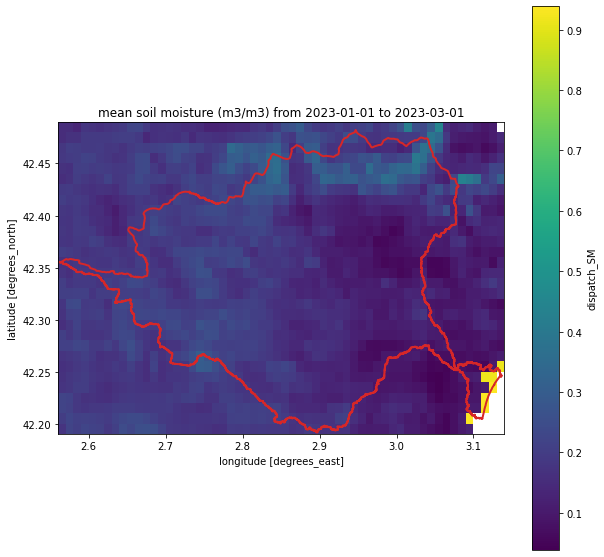

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
all_xr_sm_smap.mean(["time"]).dispatch_SM.plot(ax=ax)
shapefile.to_crs(4326).plot(ax=ax, facecolor='none', edgecolor='tab:red', lw=2)
ax.set(title=f"mean soil moisture (m3/m3) from {start_time.date()} to {end_time.date()}")